
# **fBLS** $-$ a fast-folding BLS periodogram

This notebook demonstrates the basics of the fast-folding algorithm (FFA) and fBLS, as described in the manuscript. We note that the code in this notebook is meant to illustrate and demonstrate the concept of fBLS. For conciseness and clarity, the code here is not optimized for runtime or memory use and differs from our implementation. It is also limited in scope, for example, in its period range, handling of irregular sampling, and non-constant uncertainties.

<br/>

>### *Table of contents*
>1. [*Example 1*: FFA illustration](#example1)
>  
>  1.1.[Generate mock data](#example1.1)
>
>  1.2 [The FFA step](#example1.2)
>
>2. [*Example 2*: A simple simulated lightcurve](#example2)
>
>  2.1 [Brute-force fold](#example2.1)
>
>  2.2 [Fast folding](#example2.2)
>
>  2.3 [BLS](#example2.3)
>
>3. [*Example 3*: fBLS demonstration](#example3)


System requirements: Python 3, with numpy and matplotlib.

In [1]:
import numpy as np, matplotlib.pyplot as plt

----------------

## 1.  **Example 1**: FFA illustration <a name="example1"></a>

We start by reproducing the illustration shown in Figures 1 and 2 in the fBLS paper. The goal of this example is to demonstrate FFA, in the simplistic limit of an undersampled pulse. We generate the simulated signal and then produce all `sufficiently different' phase folded lightcurves using FFA.






### 1.1. **Generate mock data** <a name="example1.1"></a>
Here, we reproduce the mock signal provided in the middle panel of Figure 1. The simulation, defined below, produces a periodic one-bin `pulse'. The value of the data is $1$ within the pulse and $0$ otherwise. For this illustration, we generate an evenly sampled lightcurve of length  $N=6\cdot2^3=48$, and cut it to $8$ consecutive sections of length $6$.


In [2]:
def generate_periodic_pulse(m=6,n=3, period=47.5/7, t0=2, reshape=False):
  '''
  Function: generate_periodic_pulse
  ---------------------------------
  Generates a mock signal, of a periodic one-bin pulse.
  Input:  m, n        - integers. Represent the lightcurve dimensions (m*2^n)
          period, t0  - floats. Trial period and time of first transit.
          reshape     - boolean. Whether to reshape the data as a matrix.
  Output: array of simulated data (one- or two-dimensitonal)
  '''

  data = np.array([
       1
       if np.abs((t-t0)%period) < 1
       else 0
       for t in np.arange(m*2**n)
       ])

  if reshape:
    return data.reshape((2**n,m))
  else:
    return data

> We now simulate a mock signal and plot it.
>
>```
>data = generate_periodic_pulse(m=6, n=3, period=6+1.25/3, t0=1.5, reshape=True)
>```


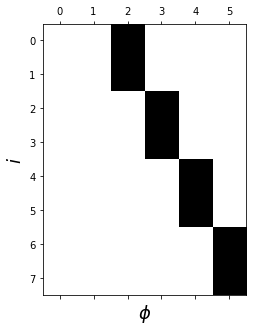

In [3]:
# Call the periodic pulse simulation routine
# ------------------------------------------
data = generate_periodic_pulse(m=6, n=3, period=6+1.25/3, t0=1.5, reshape=True)

# Figure initialization
# ---------------------
fig, axs = plt.subplots(1,1, figsize=(5,5))
_ = plt.set_cmap('gray_r')
_ = axs.matshow(data)
_ = axs.set_xlabel(r'$\phi$', fontsize=18)
_ = axs.set_ylabel(r'$i$', fontsize=18)

### 1.2. **Fast-fold illustration** <a name="example1.2"></a>

##### **Define the FFA recursion step:**
This signal is analyzed using the FFA recursive formula, given in Appendix A.
In practice, we provide all folded profiles within the period range of $6$ and $7$. The function below preforms the FFA recusion step.

In [4]:
def FFA_step(data, l, m, n):
  '''
  Function: FFA_step
  ------------------
  This routine runs a single FFA step, from level (l-1) to level (l).
  The data dimensions are given by m and n, such that the input data
  is of size m X 2^n

  Input: data    - numpy array of m X 2^n
         l, m, n - integers (see text above)

  Output: data_new - numpy array of m X 2^n
  '''

  # Initialize output matrix
  # ------------------------
  data_new = np.zeros(data.shape)

  # Initialize FFA indices
  # ----------------------
  phi      = np.arange(m, dtype=int)
  i_prime  = np.arange(2**(n-l), dtype=int)
  p        = np.arange(2**l, dtype=int)

  # Initialize the phase shift vector
  # ---------------------------------
  S = np.array([0,1], dtype=int)
  for ltmp in np.arange(1,l):
    Stmp = S+2**(ltmp-1)*np.ones_like(S, dtype=int)
    S    = np.concatenate((S, Stmp))

  # Fold
  # ----
  for pp in p:
    for ii in i_prime:
      i   = int(2**l * ii + pp)
      mu  = int(2**l * ii + np.floor(pp/2))
      nu  = int(2**l * ii + np.floor(pp/2) + 2**(l-1))

      data_new[i, phi] = data[mu, phi] + data[nu, np.mod(phi + S[pp], m)]

  return data_new

> Now, we run the fast folding analysis three times, generating the results in Figure 2.
>
>On each step we call the FFA step function, as follows:
>
> *next_level_data = FFA_step(current_level_data, level_number, m, n)*

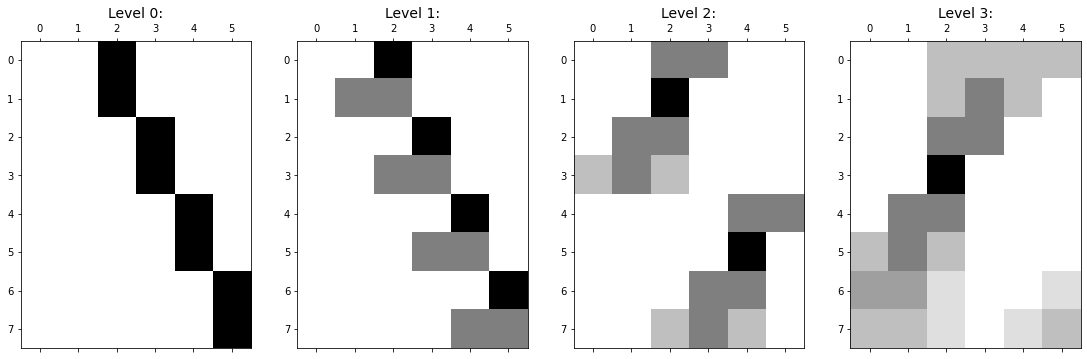

In [5]:
# Figure initialization
# ---------------------
fig, axs = plt.subplots(1,4, figsize=(19,19))
plt.set_cmap('gray_r')

# Run FFA and plot the matrix on each step
# ----------------------------------------
FFA_data = data
for ll in np.arange(4):
  if ll > 0:
    FFA_data = FFA_step(FFA_data,ll,6,3)
  _ = axs[ll].matshow(FFA_data)
  _ = axs[ll].set_title('Level ' + str(ll) + ':', fontsize=14)


----------------
## **Example 2**: A simple simulated lightcurve<a name="example2"></a>

Now, we will generate an evenly sampled lightcurve with a box-shaped transit signal with additive, uncorrelated, Gaussian noise. The routine below generates the simulation.

In [6]:
def generate_lc(m=15, n=5, period=15+4/15, width=3, t0=2, noise_level=1e-2):
  '''
  Function: generate_lc
  ---------------------
  Generates a mock lightcurve, with a rectangular transit-like signal.
  The lightcurve returned is mean subtracted. Input is similar to the
  generate_periodic_pulse function, with two addition: width (integer) is
  the number of bins in transit, and the noise_level is the std of the
  zero-centered Gaussian distribution from which the noise is sampled.
  '''
  data = np.zeros(m*2**n)
  for w in np.arange(int(width)):
    data -= generate_periodic_pulse(m=m, n=n, period=period, t0=t0+w+1)
  data += np.random.normal(0.0,noise_level,data.shape)
  data -= np.mean(data)
  return data

> Now, we can plot the example (in terms of measurement time and in terms of phase). The basic time unit is taken as the interval between consecutive measurements.

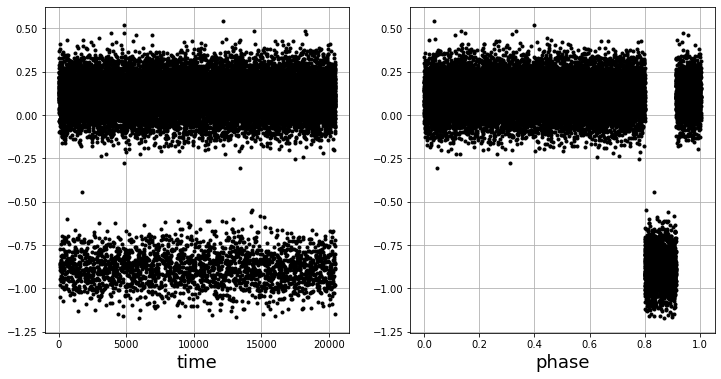

In [7]:
# Define lightcurve parameters
# ----------------------------
# Please note that in current setting the period must be larger than the
# number of bins. This requirement can be relaxed with a small modification
# to S0 (see Appendix A).
m, n        = 80, 8
period, t0  = 80.2521305, 63
noise_level = 1e-1
width       = 9

flux = generate_lc(m=m, n=n, period=period, t0=t0, width=width, noise_level=noise_level)
time = np.arange(len(flux))

# Print the lightcurve and the correct fold:
# -----------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12,6))
_ = ax[0].plot(time, flux, '.k')
_ = ax[1].plot(time%(period)/m, flux, '.k')
_ = ax[0].set_xlabel(r'time', fontsize=18)
_ = ax[1].set_xlabel(r'phase', fontsize=18)
ax[0].grid(); ax[1].grid()


### 2.1 **Brute force fold:** <a name="example2.1"></a>

Section 2.3 of the fBLS paper describes the `brute-force' folding scheme. Though we run it in this example for evenly sampled data, generally, it enables us to tackle irregularly sampled lightcurves.

In [8]:
def BF_fold(data_in, m, n, k_init=3, p_min=None):
  '''
  Function: BF_fold
  -----------------
  This is the `brute-force' routine. For an input data of dimensions m*2^n
  it produces a set of folds, produced from smaller subsections of the data,
  of length m*2^k_init.

  The requirement on the length of the input light curve is only for
  convenience and simplification of the code. This is generally not a
  requirement, as brute force can deal with different lengths and
  irregular sampling.

  Inupt: data_in - array (1D) of length m*2^n that contains the lightcurve
         m, n    - integers, the size of the input data
         k_init  - integer (see above)
         p_min   - integer, larger or equal to m. The minimal period, so that
                   folds will be generated in the interval [p_min, p_min+1]

  Output:  data_out - a matrix of folds, of level k_init.
           n_prime  - the effective size of the matrix, in terms of the
                      number of trial periods.
  '''
  # Initialize data matrix and period vector
  # -----------------------------------------
  if p_min is None:
    # The default is to search between m and m+1
    p_min, n_prime, data = m, n, data_in
  else:
    # But, we've also enabled a search between m+k and m+k+1 for
    # positive integer value of k
    n_prime       = int(np.ceil(np.log2((m/p_min)*2**n)))
    data          = (np.zeros(p_min*2**n))
    data[:m*2**n] = data_in

  # Arrange the output data matrix
  data_out = (np.zeros_like(data[:m*2**n_prime])).reshape((2**n_prime,m))
  periods  = np.array([p_min + x/(2**k_init-1) for x in np.arange(2**k_init)])

  # Cut data sections, and fold them according to the period vector
  # ---------------------------------------------------------------
  row_index    = 0
  sect_len     = p_min*2**k_init
  data_indices = np.arange(sect_len)

  # Iterate over sections
  # ---------------------
  for k in np.arange(p_min*2**n_prime//sect_len):
    data_section = data[k*sect_len : (k+1)*sect_len]

  # And for each section generate and store the folded lightcurves
  # --------------------------------------------------------------
    for p in periods:
      fold_indices = np.floor((data_indices%p)*m/p)
      fold         = np.array(
          [np.sum(data_section[np.argwhere(fold_indices==phi)])
          for phi in np.arange(m)]
          )
      data_out[row_index, :] = fold
      row_index += 1

  return data_out, n_prime

> Demonstration of the brute force folding:

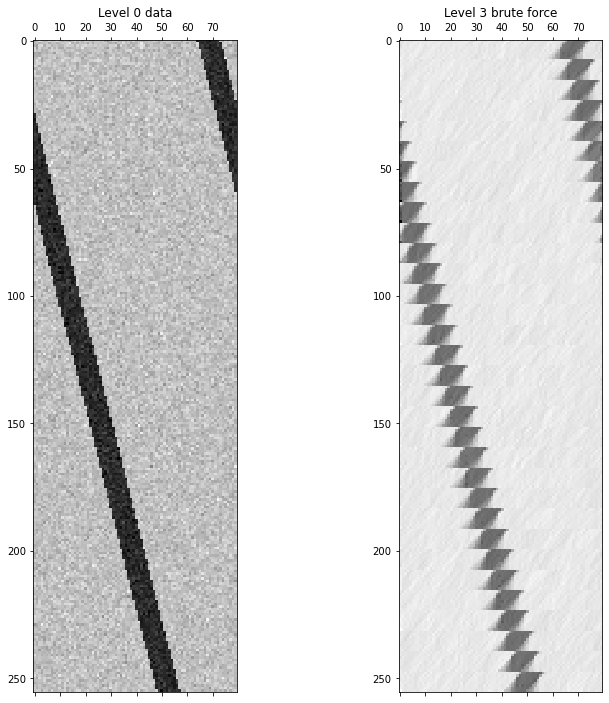

In [9]:
# Set the initialization level to 2 and the minimal period
# --------------------------------------------------------
k_init               = 3
p_min                = int(np.floor(period))

# Start with a brute force folding
# --------------------------------
# We also generate the counts matrix, in order to calculate the BLS score.
flux_BFfold, n_prime = BF_fold(flux, m, n, k_init, p_min=p_min)
count_BFfold, _      = BF_fold(np.ones_like(flux), m, n, k_init, p_min=p_min)

# Plot the brute force folded data along with the zeroth level
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12,12))
plt.set_cmap('gray')
_ = ax[0].matshow(flux.reshape((2**n,m)))
_ = ax[0].set_title('Level 0 data')
_ = ax[1].matshow(flux_BFfold)
_ = ax[1].set_title('Level ' + str(k_init) + ' brute force')


### 2.2 **Fast-folding** <a name="example2.2"></a>

Now, after the brute-force initialization, we proceed with FFA iterations.

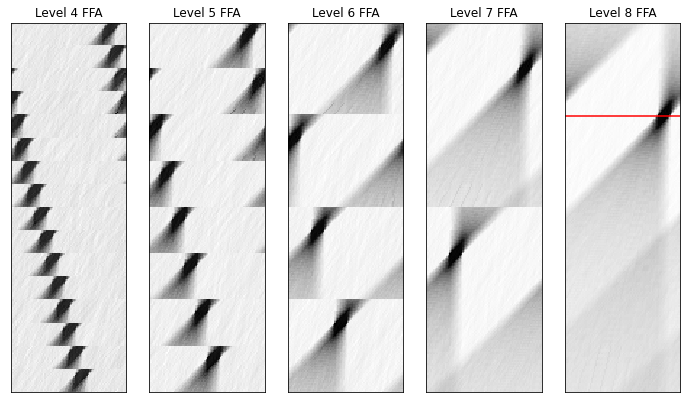

In [10]:
# Figure initialization
fig, axs = plt.subplots(1, n-k_init, figsize=(12,12))
plt.set_cmap('gray')

# Run FFA and plot the matrix on each step
# We also generate the count matrix, for the fbls calculation
F = flux_BFfold
N = count_BFfold
fig_count = 0

for ll in np.arange(k_init+1, n+1):
  if ll > k_init:
    F = FFA_step(F,ll,m,n_prime)
    N = FFA_step(N,ll,m,n_prime)
    axs[fig_count].matshow(F)
    axs[fig_count].set_title('Level ' + str(ll) + ' FFA')
    axs[fig_count].get_xaxis().set_ticks([])
    axs[fig_count].get_yaxis().set_ticks([])
    fig_count += 1
_ = axs[-1].plot(np.array([0,m-1]),np.array([period%p_min,period%p_min])*(2**(n)-1)*(2**(n_prime-n)),'-r')

### 2.3 **BLS** <a name="example2.3"></a>

For the given fold, we now calculate the SR statistic to search for the period of the transit signal. The SR calculation is done by the fBLS routine below:

In [11]:
def fBLS(F, N, max_width,m, n, p_min):
  '''
  Function: fBLS
  --------------
  This function calculates the BLS score for the set of folded lightcurves.

  Input: F, N      - the folded flux and counts matrix, respectively.
         max_width - the maximal number of bins in transit.
         m, n      - the integer representing the matrix dimensions.
         p_min     - the minimal period, so that the search is in the range [p_min, p_min + 1]

  Output: Score, Period - the BLS score and period grid vectors, respectively.
  '''
  # Calculate the s value (see equation (3) in the BLS paper):
  S = F/(m*2**n)
  twiceS = np.concatenate((S, S[:, 0:max_width+1]), axis=1)

  # Calculate the r value (see Section (2) in the BLS paper):
  R = N/(m*2**n)
  twiceR = np.concatenate((R, R[:, 0:max_width+1]), axis=1)

  # Initialize data structures, according to BLS 2002 convention
  s = np.zeros_like(S)
  r = np.zeros_like(R)

  # Convolve with a box. Define a rectangle pulse with a given window_length
  Score = np.zeros(F.shape[0])
  for i in np.arange(max_width):
    s += twiceS[:, i:i+m]
    r += twiceR[:, i:i+m]

    # SR is the score defined in the BLS paper: SR = (s**2/(r*(1-r)))**0.5
    SR = np.divide(np.abs(s), np.sqrt(r*(1-r)))
    SRmax = np.max(SR, axis=1)
    new_score_ind = SRmax > Score
    Score[new_score_ind] = SRmax[new_score_ind]

  n_prime = np.log2(m/p_min*2**n)
  Period  = p_min + np.arange(2**n)/(2**n_prime-1)

  return Score, Period

> We now calculate the SR scores for all the folds in our set of folds

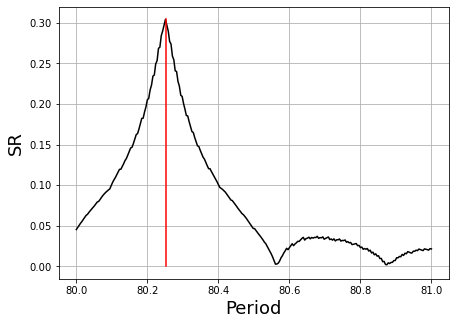

In [12]:
s, p = fBLS(F, N, 35,m, n, p_min)

plt.figure(figsize=(7,5))
plt.plot(p, s,'k')
plt.grid()
_ = plt.plot([period, period],[0, np.max(s)],'r')
_ = plt.xlabel(r'Period', fontsize=18)
_ = plt.ylabel(r'SR', fontsize=18)

<br/>
----------------
----------------
<br/>
## **Example 3**: fast BLS<a name="example3"></a>

Now, we simulate and lightcurve and generate a periodogram

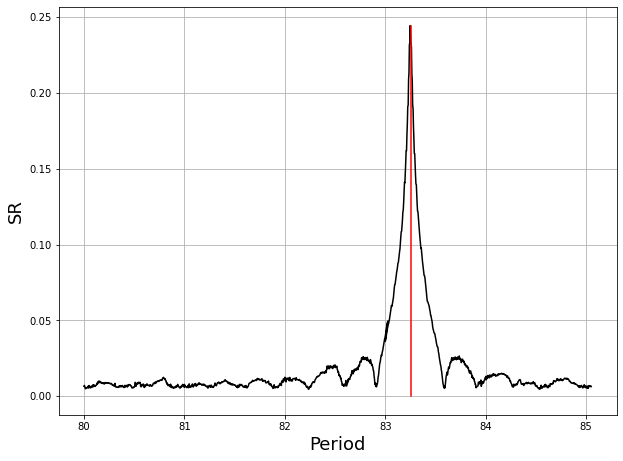

In [13]:
# Define lightcurve parameters
# ----------------------------
# Please note that in current setting the period must be larger than the
# number of bins. This requirement can be relaxed with a small modification
# to S0 (see Appendix A).
m, n         = 80, 8
period, t0   = 83.2521305, 63
noise_level  = 3e-1
width        = 6
period_range = [80, 85]

flux = generate_lc(m=m, n=n, period=period, t0=t0, width=width, noise_level=noise_level)

pers, scrs = np.array([]), np.array([])
for x in np.arange(period_range[0]-m, period_range[1]-m):
  F, n_prime = BF_fold(flux, m, n, 3, p_min=m + x)
  N, _       = BF_fold(np.ones_like(flux), m, n, k_init, p_min=m + x)

  for ll in np.arange(k_init+1, n+1):
    if ll > k_init:
      F = FFA_step(F,ll,m,n_prime)
      N = FFA_step(N,ll,m,n_prime)

  s, p = fBLS(F, N, 35,m, n, m+x)

  pers = np.append(pers, p)
  scrs = np.append(scrs, s)

plt.figure(figsize=(10,7.5))
plt.plot(pers, scrs,'k')
plt.grid()
_ = plt.plot([period, period],[0, np.max(scrs)],'r')
_ = plt.xlabel(r'Period', fontsize=18)
_ = plt.ylabel(r'SR', fontsize=18)